<a href="https://colab.research.google.com/github/nakul-gupta/flight_simulations/blob/main/ballistic_rocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
#Ballistic Rocket Simulation

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#constants
S=0.636 #Aerodynamic reference area, m^2
A_e=0.282 #Nozzle exit area, m^2
p_0=101325 #Sea level pressure, Pascals
g=9.8066 #Earth gravity acceleration, m/s^2
m_0=6000 #take off mass, kg
m_1=2000 #burn out mass, kg
t_b=70 #motor burn out time, seconds
I_sp=250 #specific impulse
R=287.053 #gas constant, Nm/(kg-K)
specific_heat=1.4 #specific heat ratio of air
m_dot = (m_0 - m_1)/t_b

#params = (S,A_e,p_0,g,m_0,m_1,t_b,I_sp,R,specific_heat,m_dot)

#transformation matrices
def geographic_to_velocity(gamma, chi):
  T_flight_path= np.array([[np.cos(gamma),0,-np.sin(gamma)],[0,1,0],[np.sin(gamma),0,np.cos(gamma)]])
  T_heading = np.array([[np.cos(chi),np.sin(chi),0],[-np.sin(chi),np.cos(chi),0],[0,0,1]])
  return T_flight_path @ T_heading

def body_to_velocity(alpha, phi):
  T_angle_of_attack= np.array([[np.cos(alpha),0,-np.sin(alpha)],[0,1,0],[np.sin(alpha),0,np.cos(alpha)]])
  T_bank = np.array([[1,0,0],[0,np.cos(phi),np.sin(phi)],[0,-np.sin(phi),np.cos(phi)]])
  return T_angle_of_attack @ T_bank

def earth_to_geographic(long, lat):
  return np.array([[-np.sin(lat)*np.cos(long), -np.sin(lat)*np.sin(long), np.cos(lat)],
                   [-np.sin(long), np.cos(long), 0],
                   [-np.cos(lat)*np.cos(long), -np.cos(lat)*np.sin(long), -np.sin(lat)]])

#rotational velocity tensors
def omega_velocity_wrt_earth(gamma, gamma_dot, chi_dot):
  return np.array([[0, -chi_dot*np.cos(gamma), gamma_dot],
                   [chi_dot*np.cos(gamma),0, chi_dot*np.sin(gamma)],
                   [-gamma_dot, -chi_dot*np.sin(gamma),0]])

#atmosphere
def standard_atmosphere(altitude):
  if altitude <= 11000:
    temp = 288.15-0.0065*altitude
    pressure = p_0*np.power(temp/288.15, 5.2559)
    density = pressure/(R*temp)
    sonic_speed = np.sqrt(specific_heat*R*temp)
    return pressure, density, sonic_speed
  if altitude > 11000 and altitude <= 80000:
    temp = 216
    pressure = 22630*np.exp(-0.00015769*(altitude-11000))
    density = pressure/(R*temp)
    sonic_speed = np.sqrt(specific_heat*R*temp)
    return pressure, density, sonic_speed
  else:
    return 0,0,0

#drag coefficient as a function of mach #
def drag_coefficient(mach):
    mach_numbers = np.array([0.0,0.5,0.8,1.05,1.5,2,3,4,8,12])
    drag_coefficients = np.array([0.292,0.311,0.645,1.241,1.096,0.957,0.833,0.776,0.723,0.651])
    return np.interp(mach, mach_numbers, drag_coefficients)

#lift coefficient as a function of mach #
def lift_coefficient(mach):
    return 0

#mass as a function of time
def mass(t):
  if t <= t_b:
    return m_0 - m_dot*t
  else:
    return m_1

#aerodynamic forces, coordinated in the velocity frame
def aerodynamics(altitude, velocity, alpha, phi):
  _, density, sonic_speed = standard_atmosphere(altitude)
  q = density*velocity*velocity/2
  mach = 0
  cd = 0
  cl = 0
  if sonic_speed != 0:
    mach = velocity/sonic_speed
    cd = drag_coefficient(mach)
    cl = lift_coefficient(mach)
  body_aero = q*S*np.array([-cd,0,-cl])
  return body_to_velocity(alpha, phi) @ body_aero

#propulsive forces, coordinated in the velocity frame
def propulsion(altitude, alpha, phi, t):
  if t > t_b:
    return body_to_velocity(alpha,phi) @ np.array([0,0,0])
  else:
    pressure, _, _ = standard_atmosphere(altitude)
    back_pressure_correction = (p_0 - pressure)*A_e
    body_thrust = np.array([I_sp*m_dot*g + back_pressure_correction,0,0])
    return body_to_velocity(alpha, phi) @ body_thrust

#gravity force, coordinated in the velocity frame
def gravity(flight_path, heading):
  return geographic_to_velocity(flight_path, heading) @ np.array([0,0,g])

#initial conditions -> [V_0, chi_0, gamma_0, s_0, s_1, s_2]
init = [90, np.radians(5), np.radians(85.9), 0, 0, -100]
time = np.arange(0,601)

#integration function, master dynamics eqn
def dynamics(states, t):
  velocity, heading, flight_path, north, east, altitude = states
  forces = (aerodynamics(-altitude, velocity, 0, 0)/mass(t) + propulsion(-altitude,0,0,t)/mass(t) + gravity(flight_path, heading))
  dV_dt = forces[0]
  dChi_dt = forces[1]/(velocity*np.cos(flight_path))
  dGamma_dt = forces[2]/(-velocity)
  dPositions = geographic_to_velocity(flight_path, heading).T @ np.array([velocity, 0, 0])
  state_derivatives = [dV_dt, dChi_dt, dGamma_dt, dPositions[0], dPositions[1], dPositions[2]]
  return state_derivatives

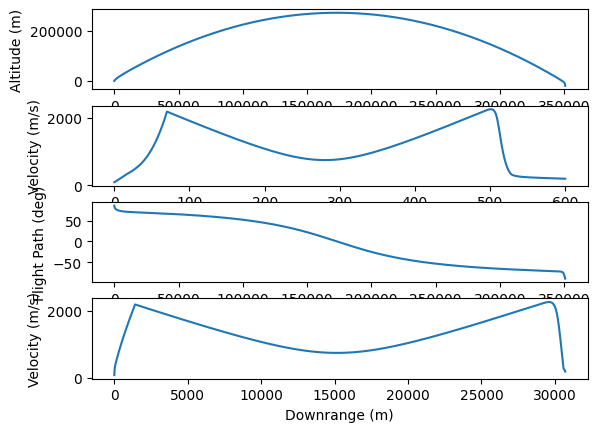

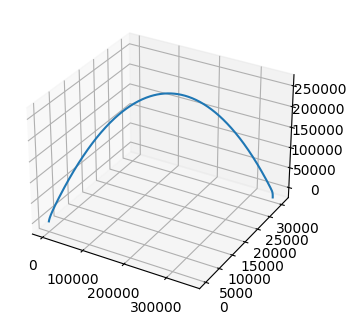

In [104]:
#solve the system of eqns
solution = odeint(dynamics, init, time)

# altitude vs downrange
plt.subplot(4, 1, 1)
plt.plot(solution[:,3], -1*solution[:, 5])
plt.xlabel('Downrange (m)')
plt.ylabel('Altitude (m)')

# Velocity vs time
plt.subplot(4, 1, 2)
plt.plot(solution[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

# flight path vs downrange
plt.subplot(4, 1, 3)
plt.plot(solution[:,3], np.degrees(solution[:, 2]))
plt.xlabel('Downrange (m)')
plt.ylabel('Flight Path (deg)')

# Velocity vs downrange
plt.subplot(4, 1, 4)
plt.plot(solution[:, 4],solution[:, 0])
plt.xlabel('Downrange (m)')
plt.ylabel('Velocity (m/s)')

#trajectory visualization
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(solution[:, 3],
        solution[:, 4],
        -1*solution[:, 5])

plt.tight_layout()